# Dynamic Mode Decomposition on Brain Network Activities during R-fMRI

Dynamic mode decomposition is a powerful data-driven method to extract spatial-temporal coherent structures( DMD modes) from high dimensional data and give you a linear model for how those evolve in time.

In the following notebook, I will use dynamic mode decomposition on time series activities of the brain to govern dominant modes of the brain. The brain activities are recorded by the fMRI method which measures brain activity by detecting changes associated with blood flow. 

# Importing essential packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import dot, multiply, diag
from numpy.linalg import inv, eig, pinv, norm, solve, cholesky
from scipy.linalg import svd, svdvals
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['svd']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading the data set

In the DMD architecture, we typically consider data collected from a dynamical system. The time series sample data used in the following notebook is a sample from the Human connectome project(HCP).  I used the result of the work of my teammate, Annabelle Harvey, (https://github.com/brainhack-school2020/harveyaa_fMRI_neuroticism/blob/master/draft_pipeline.ipynb). 

She used the pipeline from the paper "Benchmarking functional connectome-based predictive models for resting-state fMRI"(https://www.sciencedirect.com/science/article/pii/S1053811919301594)

1-Brain regions: DictLearn MODL 128 networks

2-Connectivity matrices: tangent-space representation

3-Classifier: l2-regularized logistic regression (binary)

Based on the paper the atlas used is Harvard Oxford. Lastly, she loaded fMRI images into a time series matrix.

Sample HCP ID: 180129 - R-fMRI 7T

In [2]:
data = pd.read_csv("ho_time_series180129.csv", header=None, delim_whitespace=True)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.374563,1.653623,0.964949,2.329744,0.886848,1.835090,3.047033,2.788991,-0.561395,0.992139,...,1.337249,1.201711,0.935589,0.540354,1.194318,1.559094,1.411700,0.105408,0.377848,0.295412
1,-0.261064,0.951911,-1.712871,0.186178,0.278282,1.212806,0.705359,1.867025,-0.198735,-0.546082,...,-0.295446,0.362720,-0.343685,-0.126073,0.263274,0.356907,-0.583223,-0.071444,0.304669,0.453907
2,-1.382370,-0.606124,-1.025119,-0.381678,-1.165589,-0.437467,-0.035558,0.238719,-1.006460,-0.845114,...,-1.089618,-0.178432,-2.171349,-0.681589,-1.819484,0.425533,-0.228588,0.406075,0.444734,0.864728
3,-0.872127,0.149322,-0.068868,-0.725927,-1.012422,0.133810,0.010302,0.910789,-0.365107,0.461574,...,-0.630913,-1.226801,-0.219375,-2.277682,-0.791088,-0.138593,0.322657,0.568457,0.213636,0.173589
4,-0.935543,0.008926,-0.919798,-0.084035,-0.208867,-0.555379,-0.948643,0.881303,-1.685746,0.309645,...,-0.589971,-0.768993,-1.218577,-2.000812,-0.405981,-1.236949,0.047928,-0.710475,0.471254,-0.421379


In order to prepare data as the input and output for the algorithm, we have to have a matrix in format (Brain regions $\times$ Snapshots). 

Therefore we need to transpose our data frame.

In [4]:
data_transposed = data.transpose()

In [5]:
data_transposed.head()

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,1.374563,-0.261064,-1.382370,-0.872127,-0.935543,0.647126,0.319645,1.966982,2.091892,2.022592,...,-0.768627,0.312100,0.424076,0.510709,-0.314809,0.054153,-0.580068,-1.199899,-1.749875,-0.433194
1,1.653623,0.951911,-0.606124,0.149322,0.008926,1.226259,0.778619,1.779831,1.218840,0.327491,...,-0.654568,-0.102474,-0.305885,-0.187657,-0.388792,-1.127923,-1.998227,-2.366773,-2.854285,-2.373659
2,0.964949,-1.712871,-1.025119,-0.068868,-0.919798,0.684266,1.789171,1.548612,1.230242,1.232123,...,-1.860629,-0.291199,-1.427901,-0.698515,-1.781800,-0.337276,-0.840599,-0.907400,-1.738438,0.810498
3,2.329744,0.186178,-0.381678,-0.725927,-0.084035,0.781355,0.681284,2.037673,1.106818,0.650641,...,-1.879602,-1.728567,-1.301746,-0.111107,-0.952712,-1.730460,-0.038500,-2.023280,-2.256815,-1.312675
4,0.886848,0.278282,-1.165589,-1.012422,-0.208867,1.293620,0.824425,2.470252,1.531485,0.264378,...,0.882528,0.667667,1.618585,0.581404,-0.237621,0.426374,-0.276851,-1.184813,-1.329934,0.176225


The output matrix ( data without first snapshot) is as follows:

In [6]:
X2 = data_transposed.drop(0, axis=1)
X2.head()

,1,2,3,4,5,6,7,8,9,10,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,-0.261064,-1.382370,-0.872127,-0.935543,0.647126,0.319645,1.966982,2.091892,2.022592,0.779231,...,-0.768627,0.312100,0.424076,0.510709,-0.314809,0.054153,-0.580068,-1.199899,-1.749875,-0.433194
1,0.951911,-0.606124,0.149322,0.008926,1.226259,0.778619,1.779831,1.218840,0.327491,-0.299382,...,-0.654568,-0.102474,-0.305885,-0.187657,-0.388792,-1.127923,-1.998227,-2.366773,-2.854285,-2.373659
2,-1.712871,-1.025119,-0.068868,-0.919798,0.684266,1.789171,1.548612,1.230242,1.232123,0.807722,...,-1.860629,-0.291199,-1.427901,-0.698515,-1.781800,-0.337276,-0.840599,-0.907400,-1.738438,0.810498
3,0.186178,-0.381678,-0.725927,-0.084035,0.781355,0.681284,2.037673,1.106818,0.650641,-0.810891,...,-1.879602,-1.728567,-1.301746,-0.111107,-0.952712,-1.730460,-0.038500,-2.023280,-2.256815,-1.312675
4,0.278282,-1.165589,-1.012422,-0.208867,1.293620,0.824425,2.470252,1.531485,0.264378,-0.243129,...,0.882528,0.667667,1.618585,0.581404,-0.237621,0.426374,-0.276851,-1.184813,-1.329934,0.176225


The input matrix ( data withoout last snapshot) is as follows:

In [7]:
X = data_transposed
X.drop(X.columns[len(X.columns)-1], axis=1, inplace=True)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198
0,1.374563,-0.261064,-1.382370,-0.872127,-0.935543,0.647126,0.319645,1.966982,2.091892,2.022592,...,-0.061639,-0.768627,0.312100,0.424076,0.510709,-0.314809,0.054153,-0.580068,-1.199899,-1.749875
1,1.653623,0.951911,-0.606124,0.149322,0.008926,1.226259,0.778619,1.779831,1.218840,0.327491,...,0.388999,-0.654568,-0.102474,-0.305885,-0.187657,-0.388792,-1.127923,-1.998227,-2.366773,-2.854285
2,0.964949,-1.712871,-1.025119,-0.068868,-0.919798,0.684266,1.789171,1.548612,1.230242,1.232123,...,-0.420916,-1.860629,-0.291199,-1.427901,-0.698515,-1.781800,-0.337276,-0.840599,-0.907400,-1.738438
3,2.329744,0.186178,-0.381678,-0.725927,-0.084035,0.781355,0.681284,2.037673,1.106818,0.650641,...,-1.824888,-1.879602,-1.728567,-1.301746,-0.111107,-0.952712,-1.730460,-0.038500,-2.023280,-2.256815
4,0.886848,0.278282,-1.165589,-1.012422,-0.208867,1.293620,0.824425,2.470252,1.531485,0.264378,...,0.694369,0.882528,0.667667,1.618585,0.581404,-0.237621,0.426374,-0.276851,-1.184813,-1.329934


# DMD Algorithm

DMD computes the leading eigendecomposition of the best-fit linear operator A relating the data X′ ≈ AX : 

$ A=X' X^\dag$

(X is what we have about the system in m-1 snapshots, X' is the data of the system in next snapshot, A is an operator that helps to predict the behavior of the system)

The DMD modes, also called dynamic modes, are the eigenvectors of A and each DMD mode corresponds to a particular eigenvalue of A. 

In following we are going to implement the DMD Algorithm step by step:

$\textbf{Step 1- Computing the SVD of input matrix X }$

(To find the dominant coherent structure of POD modes(proper orthogonal decomposition modes of the data matrix X)

$ X=U \Sigma V^{*} $

In [8]:
u, s, v = svd(X, False) 

Now we are going to plot what our singular values look like. Which we can pick where to truncate how many modes to keep and how many to throw away, by looking at the singular values. Indeed it is as one of the knobs that we can tune in DMD.(Truncation rank)

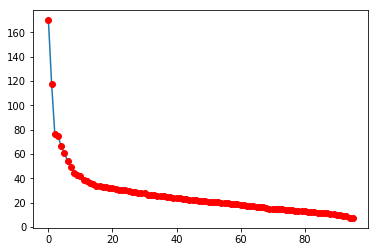

In [9]:
plt.plot(s)
plt.plot(s, 'ro')
plt.show()

In this case, we are going to keep 20 modes are throw the rest away since they have similar behaviors. If we did not want to truncate we could assume the number of all the singular values. And reduce the u, s, v by the rank of truncation, and then we are ready for next step to build reduced Ã.

In [10]:
r = 20  
U = u[:,:r]
S = diag(s)[:r,:r]
V = v.conj().T[:,:r]

$\textbf{Step 2- Compute Ã, the projection of the full matrix A onto U}$

$\tilde{A}=U^{*}AU=U^{*}X'V\Sigma ^{-1} $

In [11]:
Atilde = dot(dot(dot(U.conj().T, X2), V), inv(S))

$\textbf{Step 3- Compute the eigenvalues $λ_i$ and eigenvectors $w_i$ of Ã}$

$\tilde{A}W=W\Lambda$

In [12]:
mu,W = eig(Atilde)

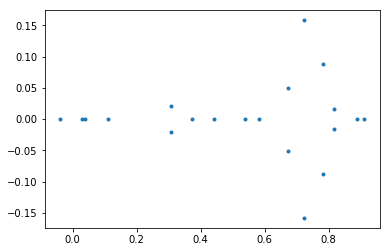

In [13]:
plt.plot(mu.real, mu.imag,'.')
plt.show()

$\textbf{Step 4- Reconstruct the eigendecomposition of A from W and  and Λ.}$

The eigenvalues for A are equivalent to those of Ã. The eigenvectors of A are given by the columns of Φ.

$ A \phi =  \phi  \Lambda $,

$ \phi = X' V \Sigma^{-1} W $
 


Now we build the exact DMD modes.

In [14]:
Phi = dot(dot(dot(X2, V), inv(S)), W)